In [15]:
import cv2 
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

In [17]:
dataset_path = "../data/fashion_small_100/"

### Feature Extraction
Extraer los features de las imagenes de la carpeta utilizando opencv con SIFT.

```keypoints, descriptors = sift.detectAndCompute(gray, None)```
- keypoints almacena las coordenadas (x,y) de cada keypoint de la imagen (esquinas, manchas, cambios bruscos de intensidad, etc).
- descriptors almacena los descriptores para cada keypoint de esa imagen (128 descriptores).

Como son muchos datos y el vector de SIFT es grande podemos utilizar reducción de dimensionalidad. Hacemos un análisis para saber cuantas componentes usamos en el PCA.

Componentes: 10 varianza acumulada: 0.577636.
Componentes: 20 varianza acumulada: 0.739846.
Componentes: 30 varianza acumulada: 0.823542.
Componentes: 40 varianza acumulada: 0.874649.
Componentes: 50 varianza acumulada: 0.910368.
Componentes: 60 varianza acumulada: 0.936108.
Componentes: 70 varianza acumulada: 0.954584.
Componentes: 80 varianza acumulada: 0.968565.
Componentes: 90 varianza acumulada: 0.979345.
Componentes: 100 varianza acumulada: 0.987589.
Componentes: 110 varianza acumulada: 0.993670.
Componentes: 120 varianza acumulada: 0.997941.


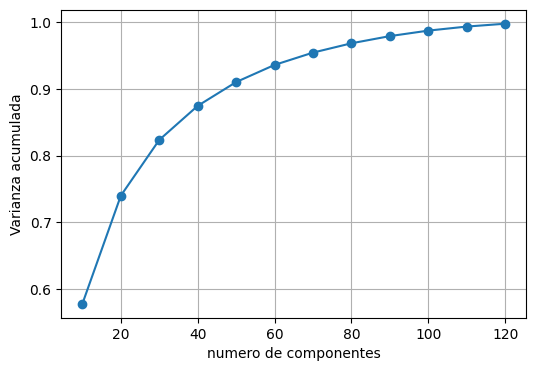

In [65]:
sift = cv2.SIFT_create()
small_dataset_path = "../data/fashion_small_100/"
all_descriptors = []

#Extraer descriptores
for filename in os.listdir(small_dataset_path): 
    file_path = os.path.join(small_dataset_path, filename)
    if os.path.isfile(file_path):
        img = cv2.imread(file_path)
        if img is None:
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        
        if descriptors is not None:
            all_descriptors.append(descriptors)


X = np.vstack(all_descriptors)  # Unir vectores en una matriz

# Aplicar pca
explained_variances = []
components_range = range(10, 130, 10)  # 10 a 120, pasos de 10

for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_var = np.sum(pca.explained_variance_ratio_)
    print(f"Componentes: {n} varianza acumulada: {explained_var:f}.")
    explained_variances.append(explained_var)

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(components_range, explained_variances, marker='o')
plt.xlabel('numero de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

In [66]:
# Extracción de descriptores
image_descriptors = [] 
sift = cv2.SIFT_create()
pca = PCA(n_components=90)

# Iterar sobre cada imagen dentro de la carpeta
for filename in os.listdir(dataset_path): 
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):
        img = cv2.imread(file_path)
        if img is None:
            print(f"No se pudo leer la imagen: {file_path}")
            continue
        
        # Convertir a grayscale y extraer descriptores
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)


        if descriptors is not None:
            image_descriptors.append(descriptors)
        else:
            print(f"No se encontraron descriptores en: {filename}")

# K-Means para construir el diccionario visual
pca.fit(np.vstack(image_descriptors))

reduced_descriptors = [pca.transform(desc) for desc in image_descriptors]


# TODO: Para el dataset completo cambiar n_clusters, ver cuales valores producen los mejores resultados
#       quizas guardar objeto kmeans en un vector si tarda mucho en generar
kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto")
kmeans.fit(np.vstack(reduced_descriptors))

# Construcción de histogramas por imagen
all_histograms = []
for descriptors in reduced_descriptors:
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    all_histograms.append(histogram)

In [67]:
def create_query_histogram(image_path, kmeans, pca): 
    sift = cv2.SIFT_create()
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        print(f"No keypoints found in image: {image_path}")
        return np.zeros(kmeans.n_clusters, dtype=float)

    descriptors_reduced = pca.transform(descriptors)
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if descriptors_reduced is not None:
        cluster_assignments = kmeans.predict(descriptors_reduced)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    return histogram

Aplicar ponderación TF-IDF

- Los documentos son las imagenes
- Los words son los clusters, cada cluster es un visual word

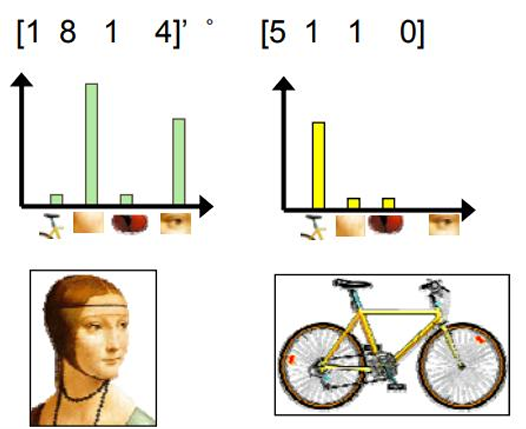

Para la imagen de la bici tengo un histograma, cuento cuantas veces aparece cada descriptor en esa imagen de la bici.

El tf seria algo como [5/7, 1/7, 1/7, 0/7] donde 7 es el total de términos en la imagen (total de palabras en el documento)
- tf = $\frac{n_{id}}{n_d}$
- idf = $log(\frac{N}{n_i})$

El df seria el número de imagenes donde el visual word i aparece (al menos una vez). *la palabra x aparece en y documentos*

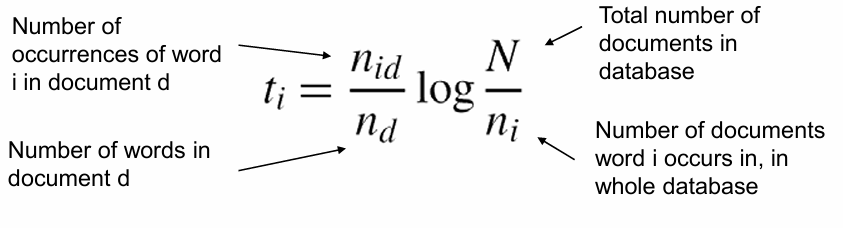

Calcular Document frequency, ejemplo:
```py
histograms = np.array([
  [3, 0, 1],   # Imagen 1
  [0, 2, 0],   # Imagen 2
  [1, 0, 5],   # Imagen 3
])
```
- Visual word 0 aparece en las imagenes 1 y 3. Image 1 and 3.
- Visual word 2 aparece en la imagen 2.
- Visual word 3 aparece en las imagenes 1 y 3.

```histograms > 0``` me da una matriz booleana. Si un visual word aparece en el documento (cluster) seria True:
```py
[
  [True,  False, True ],
  [False, True,  False],
  [True,  False, True ]
]
```
Luego con ```np.sum()```  sumo veo en cuantos documentos aparece cada visual word (cuenta los True).


In [68]:
N = len(image_descriptors) #equivalente a la cantidad de imagenes 
all_histograms = np.array(all_histograms, dtype=np.float32) 

tf = []
#for hist in all_histograms:
#    tf.append(hist / np.sum(hist)) #frecuencia de cada termino (descriptor) en el histograma[i]
tf = all_histograms  


idf = []
for i in range(kmeans.n_clusters): #i es el índice del visual word
    df = np.sum(all_histograms[:, i] > 0) # all_histograms > 0 me da una matriz de booleanos (si aparece el word o no en el doc)
    idf.append(np.log(N / (df + 1e-8))) # Sumo constante chiquita para evitar división por cero


idf_np = np.array(idf, dtype=np.float32)
tf_idf = tf * idf_np
print(tf_idf.shape) # (num_imagenes, num_clusters). tf_idf[i][j] es la importancia del visual word j en la imagen i

(100, 50)


### KNN Secuencial



Imagen 8: similitud: 0.6115
Imagen 39: similitud: 0.5238
Imagen 21: similitud: 0.5193
Imagen 10: similitud: 0.4851
Imagen 95: similitud: 0.4716
Imagen 22: similitud: 0.4208
Imagen 30: similitud: 0.3945
Imagen 56: similitud: 0.3922
Imagen 83: similitud: 0.3769
Imagen 64: similitud: 0.3730


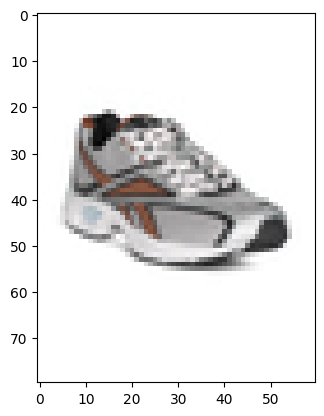

In [71]:
import heapq
image_path = "C:/Users/davie/Downloads/fashion_small/images/5730.jpg" # Path de la query
query_hist = create_query_histogram(image_path, kmeans, pca) # Procesar query
# aplico el tf_idf a la query
query = query_hist * idf_np 

k = 10

heap = []  # heapq es min-heap, popeamos si hay más de k elementos, removiendo el minimo, al final solo quedan los top k más similares
for idx, hist in enumerate(tf_idf):
    dot = np.dot(query, hist)
    norm_query = np.linalg.norm(query)
    norm_hist = np.linalg.norm(hist)

    if norm_query == 0 or norm_hist == 0:
        cosine_sim = 0 # Evitar división por cero
    else:
        cosine_sim = dot / (norm_query * norm_hist)

    heapq.heappush(heap, (cosine_sim, idx))  

    if len(heap) > k:
        heapq.heappop(heap)  # Mantiene solo los k más grandes


top_k = [(sim, idx) for sim, idx in sorted(heap, reverse=True)]
for sim, idx in top_k:
    print(f"Imagen {idx}: similitud: {sim:.4f}")

img = cv2.imread(image_path)
plt.imshow(img)


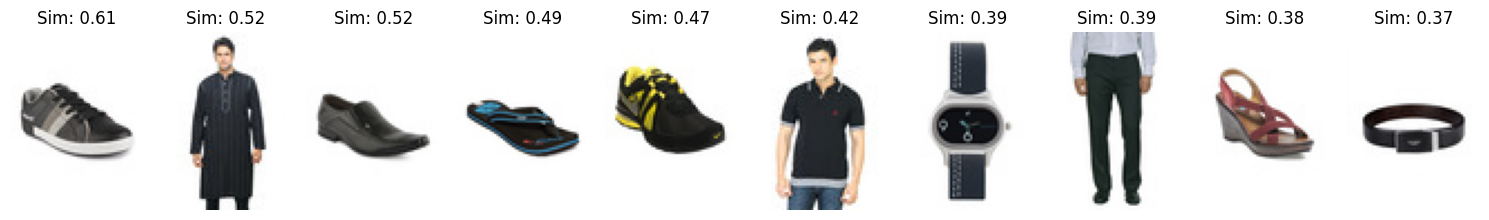

In [60]:
image_filenames = sorted([
    filename for filename in os.listdir(dataset_path)
    if filename.lower().endswith(('.jpg', '.jpeg', '.png'))
])

def show_top_similar_images(top_k, image_filenames, dataset_path):
    plt.figure(figsize=(15, 5))
    for rank, (sim, idx) in enumerate(top_k):
        img_path = os.path.join(dataset_path, image_filenames[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(1, len(top_k), rank + 1)
        plt.imshow(img)
        plt.title(f"Sim: {sim:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_top_similar_images(top_k, image_filenames, dataset_path)